In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D, Dropout

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam


from datetime import datetime
from packaging import version

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import efficientnet.tfkeras as enet


gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
        
        
        
def append_extension(fn):
    return (fn+".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[:class_number-2] = 1
    return target


DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat([response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T], axis=1)



#shuffle dataset
response = response.sample(frac=1)


data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "training",
    shuffle=True,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw', 
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "validation",
    shuffle=True,
    batch_size = 28,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw',
)

train_set.reset()
validation_set.reset()
# print(next(validation_set)[1].shape)        


import tensorflow.keras.backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def soft_acc_multi_output(y_true, y_pred):
    return K.mean(K.all(K.equal(K.cast(K.round(y_true),'int32'), K.cast(K.round(y_pred),'int32')),axis=1))

1 Physical GPUs, 1 Logical GPUs
Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [2]:
conv_base = enet.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg', weights='imagenet')
conv_base.trainable = False

In [3]:
x = conv_base.output
x = Dropout(0.5)(x)
preds = Dense(4, activation="linear")(x)
base_model = Model(inputs=conv_base.input, outputs=preds)

base_model.compile(optimizer=keras.optimizers.Adam(), loss='mse', metrics=[soft_acc_multi_output])
early_stopping = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 5, factor = 0.8)

history_1 = base_model.fit_generator(generator=train_set,
                    epochs=25,
                    verbose=0,
                    validation_data=validation_set,
                    callbacks = [early_stopping, reduce_lr_plateau]
                    )

In [4]:
train_set.reset()
validation_set.reset()

x = base_model.output
logits = Dense(4, activation='sigmoid')(x)
model =  Model(inputs=base_model.input, outputs=logits, name = r'effnet_multilogit_v1')
model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output])

In [5]:
# logdir_name = r".\tfb\logs\effnet\\" + base_model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 5, factor = 0.8)
history = model.fit_generator(generator=train_set,
                    epochs=50,
                    validation_data=validation_set,
                    callbacks = [early_stopping,reduce_lr_plateau]
                    )


Epoch 1/50
16/16 [==============================] - 6s 384ms/step - loss: 0.5183 - soft_acc_multi_output: 0.2886 - val_loss: 0.4752 - val_soft_acc_multi_output: 0.2679
Epoch 2/50
16/16 [==============================] - 5s 329ms/step - loss: 0.4336 - soft_acc_multi_output: 0.3454 - val_loss: 0.4252 - val_soft_acc_multi_output: 0.4464
Epoch 3/50
16/16 [==============================] - 5s 329ms/step - loss: 0.3977 - soft_acc_multi_output: 0.3834 - val_loss: 0.4034 - val_soft_acc_multi_output: 0.4107
Epoch 4/50
16/16 [==============================] - 5s 329ms/step - loss: 0.3741 - soft_acc_multi_output: 0.4290 - val_loss: 0.3972 - val_soft_acc_multi_output: 0.4643
Epoch 5/50
16/16 [==============================] - 5s 330ms/step - loss: 0.3724 - soft_acc_multi_output: 0.4211 - val_loss: 0.3760 - val_soft_acc_multi_output: 0.4286
Epoch 6/50
16/16 [==============================] - 5s 332ms/step - loss: 0.3594 - soft_acc_multi_output: 0.4379 - val_loss: 0.3886 - val_soft_acc_multi_output:

In [6]:
model.save(filepath ="./saved_models/my_effnet/1/my_effnet_untuned.h5", save_format='h5')

In [25]:
#########################
## fine tuning
#########################

In [5]:
import gc
try:
    del model
except NameError:
    pass
gc.collect()
model = tf.keras.models.load_model(filepath ="./saved_models/my_effnet/1/my_effnet_untuned.h5",
                                   custom_objects={'soft_acc_multi_output':soft_acc_multi_output}, compile=False)

In [7]:
fine_tune = [layer.name for layer in model.layers].index(r'block7a_bn')

model.trainable = True
for layer in model.layers[:fine_tune]:
    layer.trainable = False
for layer in model.layers[fine_tune:]:
    layer.trainable = True

print(f'from {fine_tune} of {len(model.layers)} layers; {len(model.trainable_variables)} trainables variables')
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0002), loss='binary_crossentropy', metrics=[soft_acc_multi_output])
train_set.reset()
validation_set.reset()

from 218 of 234 layers; 16 trainables variables


In [68]:
for i in model.layers[::-1]:
    print(i.name)

dense_1
dense
dropout
avg_pool
top_activation
top_bn
top_conv
block7a_project_bn
block7a_project_conv
block7a_se_excite
block7a_se_expand
block7a_se_reduce
block7a_se_reshape
block7a_se_squeeze
block7a_activation
block7a_bn
block7a_dwconv
block7a_expand_activation
block7a_expand_bn
block7a_expand_conv
block6d_add
block6d_drop
block6d_project_bn
block6d_project_conv
block6d_se_excite
block6d_se_expand
block6d_se_reduce
block6d_se_reshape
block6d_se_squeeze
block6d_activation
block6d_bn
block6d_dwconv
block6d_expand_activation
block6d_expand_bn
block6d_expand_conv
block6c_add
block6c_drop
block6c_project_bn
block6c_project_conv
block6c_se_excite
block6c_se_expand
block6c_se_reduce
block6c_se_reshape
block6c_se_squeeze
block6c_activation
block6c_bn
block6c_dwconv
block6c_expand_activation
block6c_expand_bn
block6c_expand_conv
block6b_add
block6b_drop
block6b_project_bn
block6b_project_conv
block6b_se_excite
block6b_se_expand
block6b_se_reduce
block6b_se_reshape
block6b_se_squeeze
block6b_

In [8]:
logdir_name = r".\tfb\logs\effnet\\" + model.name + '__' +  datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=21, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)

# initial epoch is useless for keras optimizers as they update internally independent of epoch number
history_fine = model.fit_generator(generator=train_set,
                    epochs=100,
                    validation_data=validation_set,
                    callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
                    )

Epoch 1/100
16/16 [==============================] - 7s 414ms/step - loss: 0.9429 - soft_acc_multi_output: 0.1272 - val_loss: 0.5529 - val_soft_acc_multi_output: 0.2500
Epoch 2/100
16/16 [==============================] - 5s 324ms/step - loss: 0.6367 - soft_acc_multi_output: 0.2692 - val_loss: 1.0615 - val_soft_acc_multi_output: 0.2321
Epoch 3/100
16/16 [==============================] - 5s 326ms/step - loss: 0.5187 - soft_acc_multi_output: 0.3634 - val_loss: 1.4417 - val_soft_acc_multi_output: 0.1429
Epoch 4/100
16/16 [==============================] - 5s 330ms/step - loss: 0.4600 - soft_acc_multi_output: 0.4196 - val_loss: 1.6073 - val_soft_acc_multi_output: 0.1607
Epoch 5/100
16/16 [==============================] - 5s 329ms/step - loss: 0.4185 - soft_acc_multi_output: 0.4525 - val_loss: 1.6200 - val_soft_acc_multi_output: 0.1786
Epoch 6/100
16/16 [==============================] - 5s 336ms/step - loss: 0.3987 - soft_acc_multi_output: 0.4488 - val_loss: 1.7554 - val_soft_acc_multi_o

KeyboardInterrupt: 

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='effnet.png', show_shapes=True)
from IPython.display import Image
Image(filename='effnet.png') 

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


FileNotFoundError: [Errno 2] No such file or directory: 'effnet.png'

tf.Tensor(0.25, shape=(), dtype=float32)


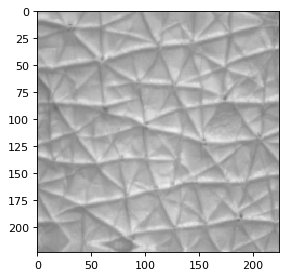

true label: [0 0 0 0]; rounded pred: [1.7566979e-03 4.6208501e-04 8.0823898e-05 5.3703785e-05]; Correct: True


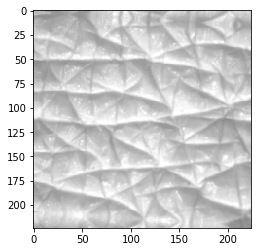

true label: [0 0 0 0]; rounded pred: [7.3167682e-04 1.5303493e-04 4.0233135e-05 2.7745962e-05]; Correct: True


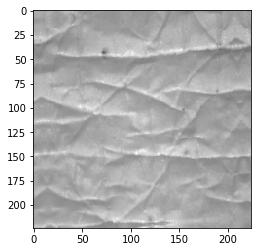

true label: [1 1 1 0]; rounded pred: [0.37728256 0.09815633 0.02522373 0.00888219]; Correct: False


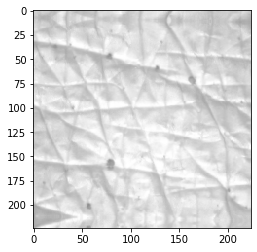

true label: [1 1 0 0]; rounded pred: [0.08229265 0.02031872 0.00414467 0.00188765]; Correct: False


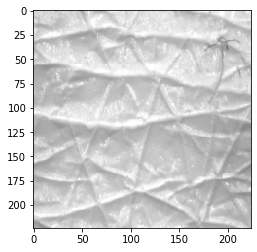

true label: [1 1 1 0]; rounded pred: [0.00689635 0.00133952 0.00027969 0.00014788]; Correct: False


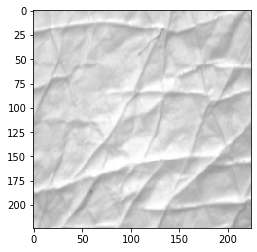

true label: [1 1 1 0]; rounded pred: [0.13281688 0.02765366 0.00414243 0.00151607]; Correct: False


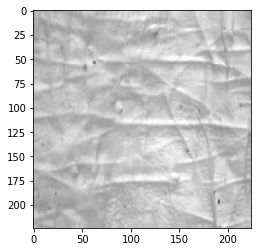

true label: [1 1 1 0]; rounded pred: [0.4118214  0.11639449 0.022396   0.00782916]; Correct: False


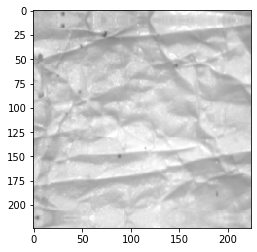

true label: [1 1 1 1]; rounded pred: [0.86253166 0.48591495 0.13673463 0.03857031]; Correct: False


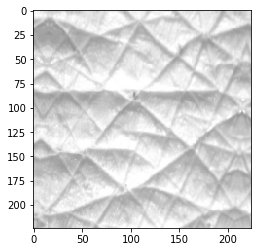

true label: [1 0 0 0]; rounded pred: [0.00799105 0.00150311 0.00040081 0.00021049]; Correct: False


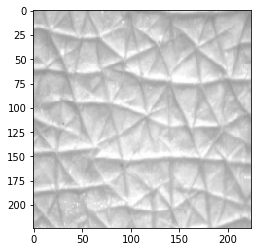

true label: [0 0 0 0]; rounded pred: [1.9502342e-03 4.5278668e-04 8.2552433e-05 5.0634146e-05]; Correct: True


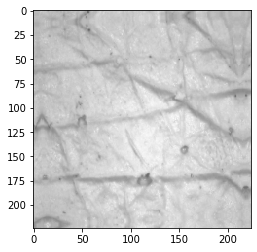

true label: [0 0 0 0]; rounded pred: [0.28262144 0.06734163 0.02258039 0.00881061]; Correct: True


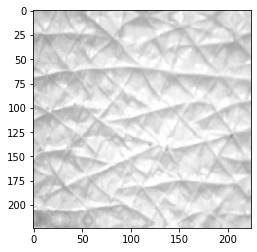

true label: [1 0 0 0]; rounded pred: [0.00897601 0.0020521  0.00031203 0.0001663 ]; Correct: False


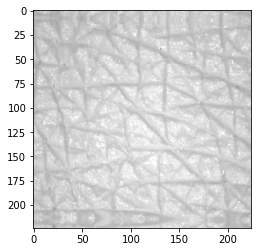

true label: [0 0 0 0]; rounded pred: [0.03702533 0.00853857 0.00188366 0.00092649]; Correct: True


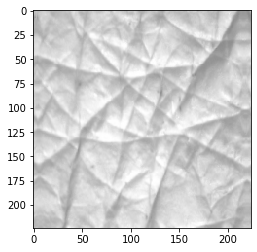

true label: [1 1 0 0]; rounded pred: [0.02562329 0.00771901 0.00352049 0.00228429]; Correct: False


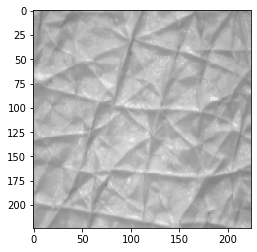

true label: [1 1 0 0]; rounded pred: [0.02121824 0.00592273 0.00121146 0.00068921]; Correct: False


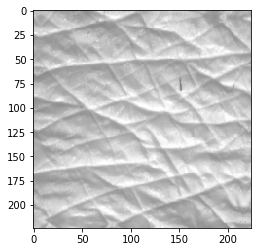

true label: [1 1 1 0]; rounded pred: [0.12396225 0.03038433 0.00735351 0.0032762 ]; Correct: False


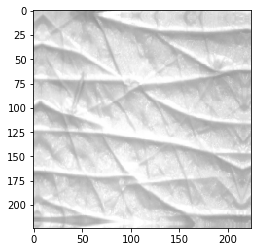

true label: [1 0 0 0]; rounded pred: [0.00646526 0.00103632 0.00025934 0.00012705]; Correct: False


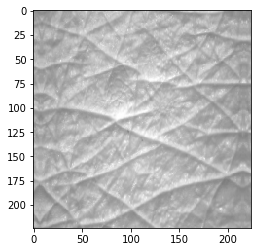

true label: [1 0 0 0]; rounded pred: [0.22799549 0.05136147 0.00573903 0.0019058 ]; Correct: False


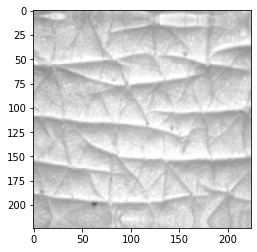

true label: [0 0 0 0]; rounded pred: [6.5630674e-04 1.6289949e-04 6.3806772e-05 5.0425529e-05]; Correct: True


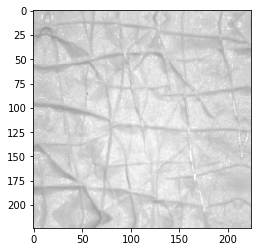

true label: [1 1 0 0]; rounded pred: [2.5327802e-03 5.0395727e-04 1.0061264e-04 5.6713820e-05]; Correct: False


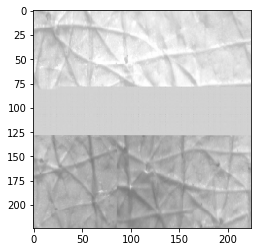

true label: [1 1 0 0]; rounded pred: [0.01384839 0.00366259 0.00098008 0.00058469]; Correct: False


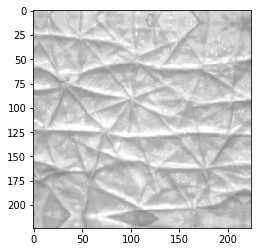

true label: [0 0 0 0]; rounded pred: [1.69390440e-03 4.21524048e-04 1.03890896e-04 7.18533993e-05]; Correct: True


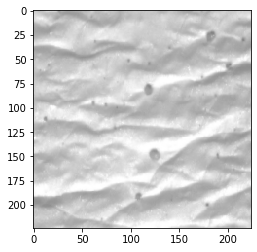

true label: [1 1 1 1]; rounded pred: [0.9098085  0.6601906  0.3101285  0.11699802]; Correct: False


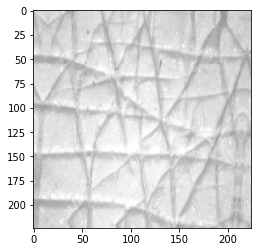

true label: [1 0 0 0]; rounded pred: [1.7493963e-04 6.3329935e-05 2.7328730e-05 3.0279160e-05]; Correct: False


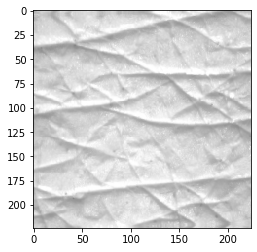

true label: [1 0 0 0]; rounded pred: [0.05906266 0.01242796 0.0037826  0.00176394]; Correct: False


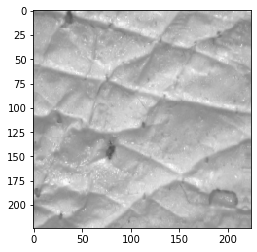

true label: [1 1 1 0]; rounded pred: [0.5881196  0.19460848 0.05178818 0.01697573]; Correct: False


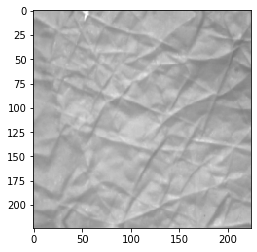

true label: [1 1 1 1]; rounded pred: [0.31331807 0.10417303 0.03638011 0.01697555]; Correct: False


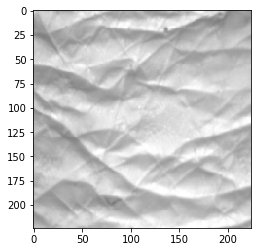

true label: [1 1 1 1]; rounded pred: [0.69932985 0.3143106  0.12873659 0.04967266]; Correct: False


In [67]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc_multi_output(y_true,y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    assert (label == y_true[i]).all()
    right = K.all(K.equal(K.cast(K.round(label),'int32'), K.cast(K.round(y_pred[i]),'int32')))
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {right}")
    
    
    
###
# notice that without fine-tuning the 